In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Đường dẫn 3 thư mục riêng biệt từ Kaggle Datasets
input_paths = {
    "with_mask": "/kaggle/input/with-mask",
    "without_mask": "/kaggle/input/without-mask",
    "mask_weared_incorrect": "/kaggle/input/mask-weared-incorrect"
}

# Thư mục output sau xử lý
output_root = "/kaggle/working/my-phone-photos-processed"
os.makedirs(output_root, exist_ok=True)

# Load model res10
prototxt_path = "/kaggle/input/res10-face-detector/deploy.prototxt"
weights_path = "/kaggle/input/res10-face-detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNetFromCaffe(prototxt_path, weights_path)

# Kích thước ảnh đầu ra
target_size = (224, 224)

def detect_and_crop_face(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()

    max_conf = 0
    box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > max_conf and confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            max_conf = confidence

    if box is not None:
        (x1, y1, x2, y2) = box.astype("int")
        face = image[y1:y2, x1:x2]
        if face.size == 0:
            return None
        face_resized = cv2.resize(face, target_size)
        return face_resized
    return None

# Xử lý từng folder
for label, folder_path in input_paths.items():
    output_folder = os.path.join(output_root, label)
    os.makedirs(output_folder, exist_ok=True)

    for filename in tqdm(os.listdir(folder_path), desc=f"Processing {label}"):
        input_path = os.path.join(folder_path, filename)
        output_path = os.path.join(output_folder, filename)

        face_img = detect_and_crop_face(input_path)
        if face_img is not None:
            cv2.imwrite(output_path, face_img)


Processing mask_weared_incorrect: 100%|██████████| 9/9 [00:00<00:00, 18.09it/s]


In [2]:
from PIL import Image
import os

input_dir = "/kaggle/working/my-phone-photos-processed"
output_dir = input_dir  # Ghi đè trong chính thư mục đó
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

for cls in classes:
    cls_path = os.path.join(input_dir, cls)
    for fname in os.listdir(cls_path):
        name, ext = os.path.splitext(fname)
        if ext.lower() == ".jpg":
            img_path = os.path.join(cls_path, fname)
            img = Image.open(img_path).convert("RGB")  # Chuyển sang RGB để đảm bảo
            new_name = f"{name}.png"
            new_path = os.path.join(cls_path, new_name)
            img.save(new_path, "PNG")
            os.remove(img_path)  # Xoá ảnh gốc .jpg nếu muốn


In [3]:
import os
import shutil

# 3 nguồn dữ liệu
dataset_base = "/kaggle/input/face-mask-detection/Dataset"
my_phone_dataset = "/kaggle/working/my-phone-photos-processed"
fmd_root = "/kaggle/input/face-mask-dataset/FMD_DATASET"

# Nơi chứa dữ liệu gộp
merged_dataset = "/kaggle/working/merged-dataset"
os.makedirs(merged_dataset, exist_ok=True)

# Các class chính
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Tạo thư mục đích cho mỗi class
for cls in classes:
    os.makedirs(os.path.join(merged_dataset, cls), exist_ok=True)

# Hàm copy có xử lý trùng tên
def safe_copy(src_path, dst_dir):
    base, ext = os.path.splitext(os.path.basename(src_path))
    dst_path = os.path.join(dst_dir, base + ext)
    count = 1
    while os.path.exists(dst_path):
        dst_path = os.path.join(dst_dir, f"{base}_{count}{ext}")
        count += 1
    shutil.copy2(src_path, dst_path)

# --------- 1. Gộp từ dataset gốc ---------
for cls in classes:
    src_dir = os.path.join(dataset_base, cls)
    dst_dir = os.path.join(merged_dataset, cls)
    if os.path.exists(src_dir):
        for filename in os.listdir(src_dir):
            safe_copy(os.path.join(src_dir, filename), dst_dir)

# --------- 2. Gộp từ ảnh điện thoại ---------
for cls in classes:
    src_dir = os.path.join(my_phone_dataset, cls)
    dst_dir = os.path.join(merged_dataset, cls)
    if os.path.exists(src_dir):
        for filename in os.listdir(src_dir):
            safe_copy(os.path.join(src_dir, filename), dst_dir)

# --------- 3. Gộp từ FMD_DATASET ---------
fmd_map = {
    "with_mask": ["complex", "simple"],
    "without_mask": ["complex", "simple"],
    "mask_weared_incorrect": ["mc", "mmc"]
}

for cls in classes:
    dst_dir = os.path.join(merged_dataset, cls)
    if cls in fmd_map:
        for subfolder in fmd_map[cls]:
            # Chuyển path đúng cho incorrect_mask
            src_root = "incorrect_mask" if cls == "mask_weared_incorrect" else cls
            src_dir = os.path.join(fmd_root, src_root, subfolder)
            if os.path.exists(src_dir):
                for filename in os.listdir(src_dir):
                    safe_copy(os.path.join(src_dir, filename), dst_dir)

print("✅ Dữ liệu từ 3 nguồn đã được gộp vào:", merged_dataset)


✅ Dữ liệu từ 3 nguồn đã được gộp vào: /kaggle/working/merged-dataset


In [4]:
import shutil

shutil.make_archive("/kaggle/working/merged-dataset", 'zip', "/kaggle/working/merged-dataset")
print("✅ Đã nén thư mục thành 'merged-dataset.zip'")

✅ Đã nén thư mục thành 'merged-dataset.zip'


In [5]:
for cls in classes:
    folder = os.path.join(merged_dataset, cls)
    print(f"{cls}: {len(os.listdir(folder))} ảnh")

with_mask: 7789 ảnh
without_mask: 7744 ảnh
mask_weared_incorrect: 8003 ảnh


In [6]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from keras import layers
from glob import glob
import keras

2025-04-18 02:02:58.176001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744941778.509389      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744941778.586462      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
import os
from collections import Counter

# Đường dẫn thư mục gộp
merged_dataset = "/kaggle/working/merged-dataset"

# Tên các class
classes = ["with_mask", "without_mask", "mask_weared_incorrect"]

# Bộ đếm định dạng ảnh
ext_counter = Counter()

for cls in classes:
    cls_dir = os.path.join(merged_dataset, cls)
    if os.path.exists(cls_dir):
        for filename in os.listdir(cls_dir):
            ext = os.path.splitext(filename)[1].lower()
            ext_counter[ext] += 1

print("📸 Định dạng ảnh trong merged-dataset:")
for ext, count in ext_counter.items():
    print(f"{ext}: {count} ảnh")


📸 Định dạng ảnh trong merged-dataset:
.png: 9000 ảnh
.jpg: 14536 ảnh


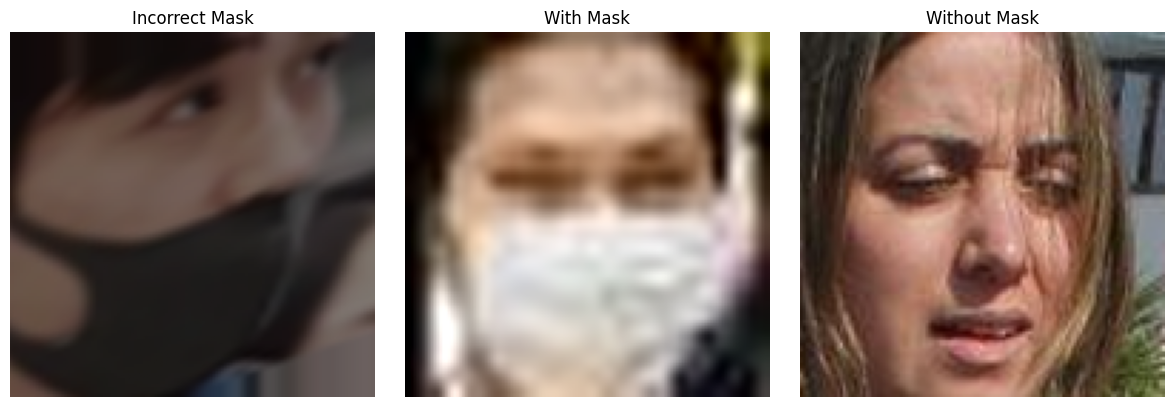

In [8]:
from glob import glob
import matplotlib.pyplot as plt
import os

dataset_path = '/kaggle/working/merged-dataset'

# Lấy ảnh có đuôi .jpg, .jpeg, .png
def get_all_images(path):
    return glob(os.path.join(path, "*.png")) + \
           glob(os.path.join(path, "*.jpg")) + \
           glob(os.path.join(path, "*.jpeg"))

# Lấy đường dẫn ảnh cho từng class
mask_weared_incorrect = get_all_images(os.path.join(dataset_path, "mask_weared_incorrect"))
with_mask = get_all_images(os.path.join(dataset_path, "with_mask"))
without_mask = get_all_images(os.path.join(dataset_path, "without_mask"))

# Visualize sample images
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(plt.imread(mask_weared_incorrect[0]))
ax[0].set_title("Incorrect Mask")
ax[1].imshow(plt.imread(with_mask[0]))
ax[1].set_title("With Mask")
ax[2].imshow(plt.imread(without_mask[0]))
ax[2].set_title("Without Mask")
for a in ax:
    a.axis("off")
plt.tight_layout()
plt.show()


Found 18831 images belonging to 3 classes.
Found 4705 images belonging to 3 classes.


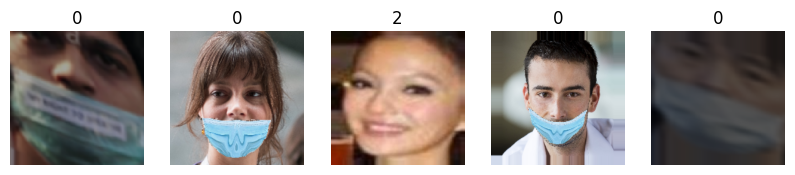

In [9]:
datagen = ImageDataGenerator(
    rescale = 1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2  # 80% training, 20% validation
)

# Updated image size to (224,224)
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = (224, 224),  
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation'
)

# Visualizing a batch of training images and their labels
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5, i+1)
    plt.imshow(x_batch[i])
    plt.title(np.argmax(y_batch[i]))  # Display class
    plt.axis('off')
plt.show()

In [10]:
base_model = MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  # Output 3 classes

model = Model(inputs= base_model.input, outputs = x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

2025-04-18 02:03:14.238940: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model3.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

In [12]:
history = model.fit(
    train_generator,
    epochs=20,  # Increased number of epochs
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stop]  # Add callbacks
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/589 ━━━━━━━━━━━━━━━━━━━━ 7:43 993ms/step - accuracy: 0.7993 - loss: 0.4862

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 980ms/step - accuracy: 0.8896 - loss: 0.2798
Epoch 1: val_accuracy improved from -inf to 0.91392, saving model to best_model3.keras
589/589 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.8897 - loss: 0.2796 - val_accuracy: 0.9139 - val_loss: 0.2209
Epoch 2/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9630 - loss: 0.1060
Epoch 2: val_accuracy improved from 0.91392 to 0.96004, saving model to best_model3.keras
589/589 ━━━━━━━━━━━━━━━━━━━━ 762s 1s/step - accuracy: 0.9630 - loss: 0.1060 - val_accuracy: 0.9600 - val_loss: 0.1080
Epoch 3/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9679 - loss: 0.0882
Epoch 3: val_accuracy improved from 0.96004 to 0.96153, saving model to best_model3.keras
589/589 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.9679 - loss: 0.0882 - val_accuracy: 0.9615 - val_loss: 0.1015
Epoch 4/20
589/589 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9763 - loss: 0.0662
Epoch 4: val_accuracy did not improve from 0.96

In [13]:
# Load the best model
model.load_weights('best_model3.keras')

# Evaluate on validation data
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')

148/148 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.9825 - loss: 0.0544
Validation Accuracy: 98.09%



**Fine-Tuning the Model (Unfreezing MobileNetV2)
We unfreeze the MobileNetV2 base model and fine-tune the entire model with a lower learning rate.
Fine-tuning helps improve the model's performance by allowing it to adjust the weights of pre-trained layers.**


In [14]:
import os
import shutil
import random
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm

# Gốc dataset
root_dir = Path("/kaggle/input/face-mask-dataset/FMD_DATASET")

# Nơi lưu tập test
test_dir = Path("/kaggle/working/test")
test_dir.mkdir(parents=True, exist_ok=True)

# Copy nguyên bản để làm việc (nếu muốn giữ nguyên bộ gốc)
train_dir = Path("/kaggle/working/train")
shutil.copytree(root_dir, train_dir, dirs_exist_ok=True)

# Đổi tên class cho phù hợp với yêu cầu
class_map = {
    "with_mask": "with_mask",
    "without_mask": "without_mask",
    "incorrect_mask": "mask_weared_incorrect"
}

summary = []

# Lặp qua từng class chính
for raw_class in tqdm(["with_mask", "without_mask", "incorrect_mask"], desc="Processing Classes"):
    raw_class_path = train_dir / raw_class
    test_class_name = class_map[raw_class]
    test_class_path = test_dir / test_class_name
    test_class_path.mkdir(parents=True, exist_ok=True)

    all_images = []

    # Duyệt tất cả ảnh trong các subfolder
    for subfolder in os.listdir(raw_class_path):
        sub_path = raw_class_path / subfolder
        if not sub_path.is_dir():
            continue
        for img_file in os.listdir(sub_path):
            full_path = sub_path / img_file
            all_images.append(full_path)

    # Lấy 50% ảnh để chuyển sang test
    test_images = random.sample(all_images, len(all_images) // 2)
    for img_path in test_images:
        shutil.move(str(img_path), str(test_class_path / img_path.name))

    # Tổng kết
    summary.append({
        "Class": test_class_name,
        "Total": len(all_images),
        "Test": len(test_images),
        "Train": len(all_images) - len(test_images)
    })

# Hiển thị bảng thống kê
df_summary = pd.DataFrame(summary)
df_summary


Processing Classes:   0%|          | 0/3 [00:00<?, ?it/s]

,Class,Total,Test,Train
0,with_mask,4789,2394,2395
1,without_mask,4747,2373,2374
2,mask_weared_incorrect,5000,2500,2500


In [15]:
!ls

best_model3.keras  merged-dataset.zip	      __notebook__.ipynb  train
merged-dataset	   my-phone-photos-processed  test


Found 6629 images belonging to 3 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


208/208 ━━━━━━━━━━━━━━━━━━━━ 188s 891ms/step
Classification Report:
                       precision    recall  f1-score   support

mask_weared_incorrect       0.98      0.99      0.99      1862
            with_mask       0.98      0.99      0.99      2394
         without_mask       1.00      0.98      0.99      2373

             accuracy                           0.99      6629
            macro avg       0.99      0.99      0.99      6629
         weighted avg       0.99      0.99      0.99      6629



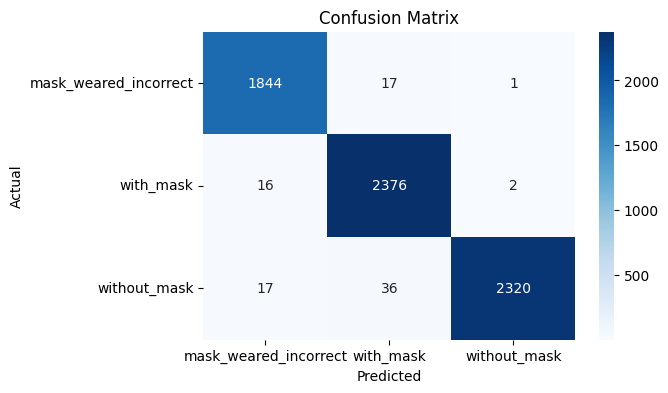

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Đường dẫn test
test_path = "/kaggle/working/test"

# Image generator cho test (không cần augment)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),  # chỉnh theo input của model
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # rất quan trọng để giữ đúng thứ tự label
)

# Dự đoán
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Báo cáo đánh giá
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


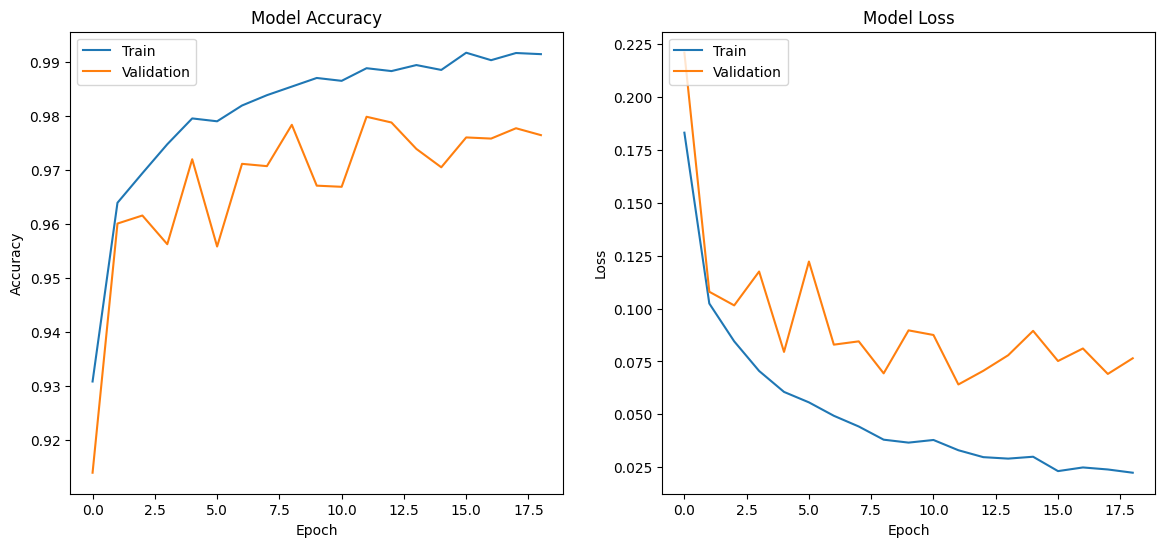

In [17]:
# Plot training & validation accuracy
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


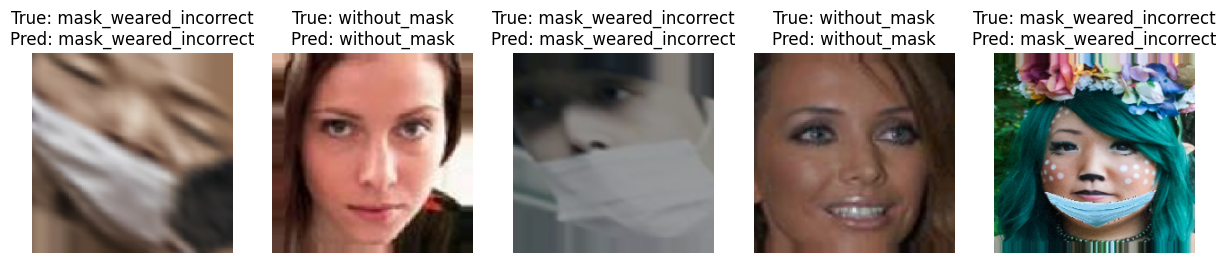

In [18]:
def visualize_predictions(generator, model, num_images=5):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    class_labels = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}')
        plt.axis('off')
    plt.show()

visualize_predictions(validation_generator, model)

In [19]:
model.save('/kaggle/working/mask_detection_model3.keras')

[INFO] Model loaded ✅
🔍 images.jpg


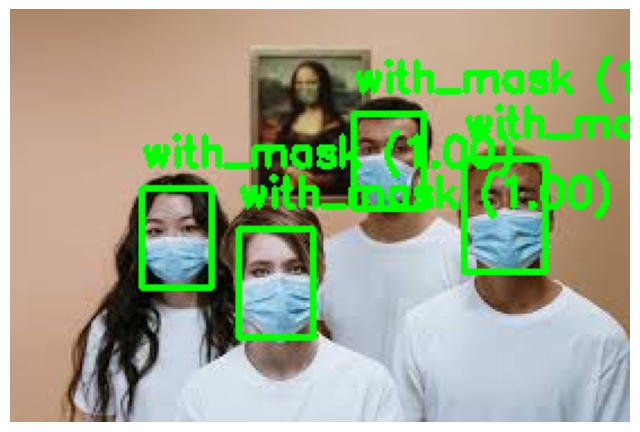

🔍 6.jpg


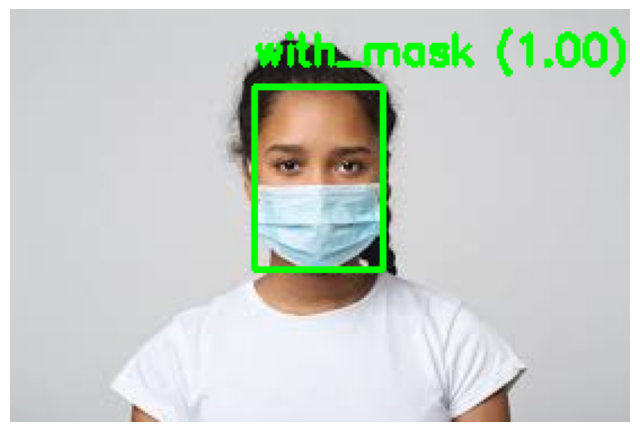

🔍 1.png


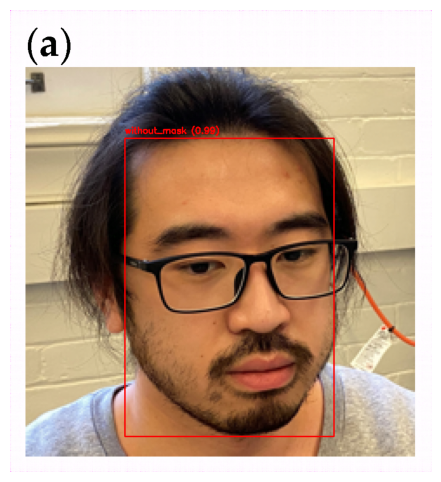

🔍 5.jpg


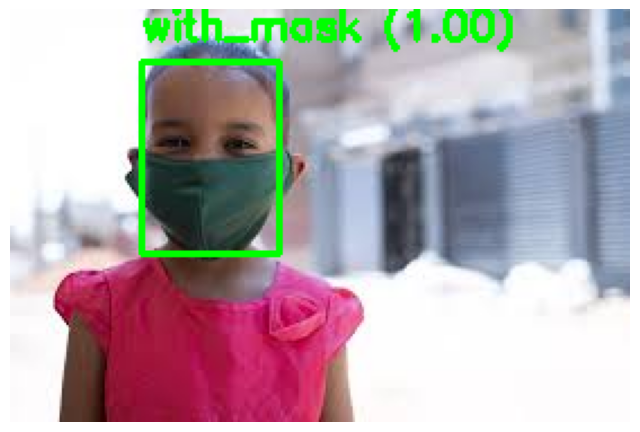

🔍 4.png


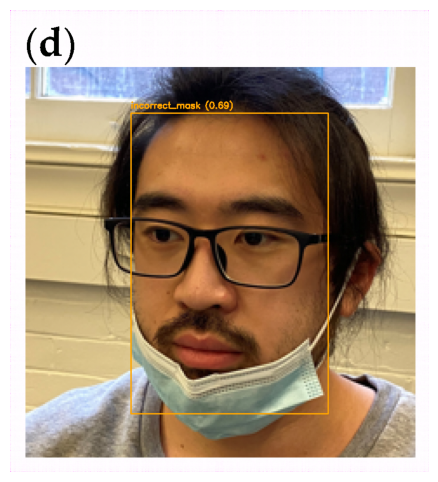

In [20]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random  # Thêm thư viện random

# === 1. Load model đã train ===
model = load_model("/kaggle/working/best_model3.keras")  # Đổi đúng tên thư mục
print("[INFO] Model loaded ✅")

# === 2. Load face detector Res10 ===
prototxt = "/kaggle/input/res10-face-detector/deploy.prototxt"
weights = "/kaggle/input/res10-face-detector/res10_300x300_ssd_iter_140000.caffemodel"
face_net = cv2.dnn.readNetFromCaffe(prototxt, weights)

# === 3. Hàm detect + dự đoán + vẽ ===
def predict_and_draw(image_path, model, face_net, input_size=(224, 224), threshold=0.5):
    image = cv2.imread(image_path)
    orig = image.copy()
    h, w = image.shape[:2]

    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), [104, 117, 123])
    face_net.setInput(blob)
    detections = face_net.forward()

    labels = ["incorrect_mask", "with_mask", "without_mask"]
    
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if conf < threshold:
            continue

        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (x1, y1, x2, y2) = box.astype("int")

        # Crop và chuẩn hóa khuôn mặt
        face = image[y1:y2, x1:x2]
        if face.size == 0:
            continue

        face = cv2.resize(face, input_size)
        face = face.astype("float32") / 255.0
        face = np.expand_dims(face, axis=0)

        preds = model.predict(face, verbose=0)
        idx = np.argmax(preds[0])
        label = labels[idx]
        score = preds[0][idx]

        # Vẽ bounding box + label
        text = f"{label} ({score:.2f})"
        color = (0, 255, 0) if label == "with_mask" else ((0, 0, 255) if label == "without_mask" else (0, 165, 255))
        cv2.rectangle(orig, (x1, y1), (x2, y2), color, 2)
        cv2.putText(orig, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # Chuyển BGR sang RGB để hiển thị bằng matplotlib
    rgb_img = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(rgb_img)
    plt.axis("off")
    plt.show()
# Đổi thành tên thư mục bạn upload chứa ảnh
input_dir = "/kaggle/input/testdata"
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# ✅ Lấy ngẫu nhiên 10 ảnh
random_images = random.sample(image_files, min(5, len(image_files)))  # Tránh lỗi nếu <10 ảnh

for img_name in random_images:
    img_path = os.path.join(input_dir, img_name)
    print(f"🔍 {img_name}")
    predict_and_draw(img_path, model, face_net)


In [21]:
pip install keras-flops

Note: you may need to restart the kernel to use updated packages.


In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

# ==== Load model ====
model = load_model("/kaggle/working/best_model3.keras")
print("✅ Model loaded")

# ==== Tính FLOPs ====
def get_flops(model, image_size=224):
    full_model = tf.function(lambda x: model(x))
    concrete_func = full_model.get_concrete_function(
        tf.TensorSpec([1, image_size, image_size, 3], tf.float32)
    )
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph, run_meta=run_meta, cmd="op", options=opts)
    
    return flops.total_float_ops / 1e9  # GFLOPs

# ==== Tính toán ====
input_size = 224  # Đổi theo model bạn dùng (ví dụ 224, 128,...)
bflops = get_flops(model, input_size)
print(f"📊 Model FLOPs: {bflops:.2f} BFLOPs")


✅ Model loaded


I0000 00:00:1744957083.484495      13 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1744957083.485126      13 single_machine.cc:361] Starting new session



=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. Note: Please read the implementation for th